In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "./ppd_data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
WORD_EMBED_PATH = DATA_PATH + "word_embed.txt"
CHAR_EMBED_PATH = DATA_PATH + "cahr_embed.txt"
QUEST_PATH = DATA_PATH + "question.csv"

In [3]:
questions = pd.read_csv(QUEST_PATH)
questions.head()

,qid,words,chars
0,Q000000,W05733 W05284 W09158 W14968 W07863,L1128 L1861 L2218 L1796 L1055 L0847 L2927
1,Q000001,W17378 W17534 W03249 W01490 W18802,L2214 L1980 L0156 L1554 L2218 L1861 L3019 L010...
2,Q000002,W17378 W08158 W20171 W11246 W14759,L2214 L2350 L2568 L1969 L2168 L0694 L3012 L256...
3,Q000003,W11385 W14103 W02556 W13157 W09749,L0762 L2172 L1971 L2034 L2039 L2271 L1346 L223...
4,Q000004,W17508 W18238 W02952 W18103,L0018 L2321 L1346 L3019 L0104 L0902 L0354 L0362


In [4]:
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,label,q1,q2
0,1,Q397345,Q538594
1,0,Q193805,Q699273
2,0,Q085471,Q676160
3,0,Q189314,Q438123
4,0,Q267714,Q290126


In [5]:
test_data = pd.read_csv(TEST_PATH)
test_data.head()

,q1,q2
0,Q017571,Q006012
1,Q728241,Q542572
2,Q166997,Q118270
3,Q422420,Q514386
4,Q354329,Q032485


# Analyse

the basic information of both train data and test data.

conclusion:

1. data is balanced

In [6]:
print("number of train question pairs:", len(train_data))
print("number of train unique first question: %s, with rate: %s" % 
      (len(train_data["q1"].unique()), len(train_data["q1"].unique()) / len(train_data)))
print("number of train unique second question: %s, with rate: %s" % 
      (len(train_data["q2"].unique()), len(train_data["q2"].unique()) / len(train_data)))

train_unique_q = np.concatenate([train_data["q2"].unique(), train_data["q1"].unique()])
train_unique_q = np.unique(train_unique_q)
print("total number of train question:", len(train_unique_q))

pos_mask = train_data["label"] == 1
neg_mask = train_data["label"] == 0
print("positive pair number: %s, negative pair number: %s, positive rate: %.3f" %
      (pos_mask.sum(), neg_mask.sum(), pos_mask.sum() / len(train_data)))

number of train question pairs: 254386
number of train unique first question: 112296, with rate: 0.4414393873876707
number of train unique second question: 112404, with rate: 0.4418639390532498
total number of train question: 192633
positive pair number: 132054, negative pair number: 122332, positive rate: 0.519


In [7]:
print("number of test question pairs:", len(test_data))
print("number of test unique first question: %s, with rate: %s" % 
      (len(test_data["q1"].unique()), len(test_data["q1"].unique()) / len(test_data)))
print("number of test unique second question: %s, with rate: %s" % 
      (len(test_data["q2"].unique()), len(test_data["q2"].unique()) / len(test_data)))

test_unique_q = np.concatenate([test_data["q2"].unique(), test_data["q1"].unique()])
test_unique_q = np.unique(test_unique_q)
print("total number of test question:", len(test_unique_q))

number of test question pairs: 172956
number of test unique first question: 131768, with rate: 0.7618585073660353
number of test unique second question: 131496, with rate: 0.7602858530493305
total number of test question: 248773


In [8]:
from collections import Counter

train_question = np.concatenate([train_data["q1"], train_data["q2"]])
test_question = np.concatenate([test_data["q1"], test_data["q2"]])
train_counter = Counter(train_question)
test_counter = Counter(test_question)
print(train_counter.most_common(10))
print(test_counter.most_common(10))

[('Q489328', 112), ('Q119369', 109), ('Q632400', 109), ('Q382228', 108), ('Q081677', 107), ('Q555455', 107), ('Q149996', 105), ('Q436579', 105), ('Q143237', 105), ('Q424359', 104)]
[('Q066137', 34), ('Q209532', 31), ('Q526780', 31), ('Q665740', 29), ('Q405292', 28), ('Q092597', 28), ('Q195819', 26), ('Q150486', 26), ('Q263180', 26), ('Q492945', 25)]


In [9]:
both = []
for q in train_counter:
    if q in test_counter:
        both.append(q)
print("the number of questions in both train and test:", len(both))

the number of questions in both train and test: 34815


**there may be some tricks to improve lb performence with these duplicated question.**

In [10]:
words = questions["words"].str.split(" ").tolist()
chars = questions["chars"].str.split(" ").tolist()

In [11]:
from gensim.corpora import Dictionary

word_dict = Dictionary(words)
char_dict = Dictionary(chars)

In [12]:
print("number of words: %d, number of chars: %d" % (len(word_dict.dfs), len(char_dict.dfs)))

number of words: 20890, number of chars: 3048


In [13]:
word_series = pd.Series(list(word_dict.dfs.values()), index=list(word_dict.dfs.keys()), name="count").sort_values(ascending=False)
word_prop = word_series / len(questions) / 2 * 100
word_prop.name = "prop"
word_df = pd.concat([word_series, word_prop], axis=1)
word_df.head(10)

,count,prop
7,225209,15.458563
27,151787,10.418806
36,147457,10.121591
22,127924,8.780827
21,112820,7.744074
1,92782,6.368646
64,90549,6.215371
2,80819,5.547494
5,74949,5.144572
0,71344,4.897121


In [14]:
char_series = pd.Series(list(char_dict.dfs.values()), index=list(char_dict.dfs.keys()), name="count").sort_values(ascending=False)
char_prop = char_series / len(questions) / 2 * 100
char_prop.name = "prop"
char_df = pd.concat([char_series, char_prop], axis=1)
char_df.head(10)

,count,prop
7,270887,18.593945
12,243693,16.727322
4,212914,14.614622
56,177513,12.184663
13,172025,11.807962
36,164027,11.258971
5,157696,10.824405
42,154583,10.610726
2,130525,8.959362
32,112820,7.744074


In [15]:
questions["words"] = questions["words"].str.split(" ")
questions["chars"] = questions["chars"].str.split(" ")
questions.head()

,qid,words,chars
0,Q000000,"[W05733, W05284, W09158, W14968, W07863]","[L1128, L1861, L2218, L1796, L1055, L0847, L2927]"
1,Q000001,"[W17378, W17534, W03249, W01490, W18802]","[L2214, L1980, L0156, L1554, L2218, L1861, L30..."
2,Q000002,"[W17378, W08158, W20171, W11246, W14759]","[L2214, L2350, L2568, L1969, L2168, L0694, L30..."
3,Q000003,"[W11385, W14103, W02556, W13157, W09749]","[L0762, L2172, L1971, L2034, L2039, L2271, L13..."
4,Q000004,"[W17508, W18238, W02952, W18103]","[L0018, L2321, L1346, L3019, L0104, L0902, L03..."


In [16]:
train_list = train_data.merge(questions, how="left", left_on="q1", right_on="qid").drop("qid", axis=1)
train_list = train_list.rename(columns={"words": "w1", "chars": "c1"})
train_list = train_list.merge(questions, how="left", left_on="q2", right_on="qid").drop("qid", axis=1)
train_list = train_list.rename(columns={"words": "w2", "chars": "c2"})
train_list["wnum1"] = train_list["w1"].map(len)
train_list["cnum1"] = train_list["c1"].map(len)
train_list["wnum2"] = train_list["w2"].map(len)
train_list["cnum2"] = train_list["c2"].map(len)
train_list["wboth"] = train_list.apply(lambda x: len([t for t in x["w1"] if t in x["w2"]]), axis=1)
train_list["cboth"] = train_list.apply(lambda x: len([t for t in x["c1"] if t in x["c2"]]), axis=1)
train_list.head()

,label,q1,q2,w1,c1,w2,c2,wnum1,cnum1,wnum2,cnum2,wboth,cboth
0,1,Q397345,Q538594,"[W04465, W04058, W05284, W02916]","[L2218, L2568, L0360, L0242, L2218, L0741]","[W18238, W18843, W01490, W09905]","[L3019, L0104, L0582, L2218, L1861, L1556, L0242]",4,6,4,7,0,3
1,0,Q193805,Q699273,"[W10054, W04476, W09996, W12244, W18103]","[L2376, L2168, L0050, L1187, L0104, L2432, L09...","[W18439, W00863, W04259, W00740, W16070]","[L0156, L2452, L1187, L0104, L2459, L2979, L26...",5,10,5,8,0,2
2,0,Q085471,Q676160,"[W04346, W17378, W19355, W17926, W14185, W1156...","[L2323, L1526, L2214, L1132, L2723, L1861, L22...","[W14586, W09745, W06017, W09067, W16319]","[L2568, L0971, L1291, L0358, L0037, L2582]",7,10,5,6,0,0
3,0,Q189314,Q438123,"[W17508, W09996, W19662, W17534, W11399, W1705...","[L0018, L2321, L1346, L2432, L0902, L1149, L19...","[W18238, W02357, W06606]","[L3019, L0104, L1104, L1935, L1683, L2495, L2812]",8,14,3,7,1,2
4,0,Q267714,Q290126,"[W13157, W03390, W01952, W05789, W17378, W0871...","[L2271, L1346, L1389, L2932, L0466, L2218, L19...","[W04476, W06606, W00316, W13157]","[L0050, L1187, L0104, L1683, L2495, L2812, L15...",7,12,4,10,2,4


In [17]:
test_list = test_data.merge(questions, how="left", left_on="q1", right_on="qid").drop("qid", axis=1)
test_list = test_list.rename(columns={"words": "w1", "chars": "c1"})
test_list = test_list.merge(questions, how="left", left_on="q2", right_on="qid").drop("qid", axis=1)
test_list = test_list.rename(columns={"words": "w2", "chars": "c2"})
test_list["wnum1"] = test_list["w1"].map(len)
test_list["cnum1"] = test_list["c1"].map(len)
test_list["wnum2"] = test_list["w2"].map(len)
test_list["cnum2"] = test_list["c2"].map(len)
test_list["wboth"] = test_list.apply(lambda x: len([t for t in x["w1"] if t in x["w2"]]), axis=1)
test_list["cboth"] = test_list.apply(lambda x: len([t for t in x["c1"] if t in x["c2"]]), axis=1)
test_list.head()

,q1,q2,w1,c1,w2,c2,wnum1,cnum1,wnum2,cnum2,wboth,cboth
0,Q017571,Q006012,"[W17342, W06766, W04049, W16319, W07863]","[L0358, L0143, L0942, L1872, L1236, L3046, L00...","[W11668, W17378, W11399, W14113]","[L1791, L2214, L1872, L1236, L0947, L2323]",5,9,4,6,0,2
1,Q728241,Q542572,"[W17378, W17534, W02000, W19499, W05016, W0644...","[L2214, L1980, L1526, L2669, L0590, L2812, L05...","[W10157, W13631, W11299, W07863]","[L1796, L2568, L0127, L0004, L0030, L2120, L2927]",8,12,4,7,1,3
2,Q166997,Q118270,"[W17378, W19355, W03914, W18238, W03746]","[L2214, L1132, L2292, L0158, L3019, L0104, L01...","[W19468, W10157, W02288, W18951, W18448]","[L2253, L1796, L2568, L0156, L0762, L1486, L22...",5,8,5,8,0,3
3,Q422420,Q514386,"[W16938, W17867, W18843, W01490, W06036]","[L2172, L1074, L0582, L2218, L1861, L2705, L1037]","[W01490, W00496]","[L2218, L1861, L0377, L2619]",5,7,2,4,1,2
4,Q354329,Q032485,"[W17378, W19355, W01490, W11030, W19349, W1839...","[L2214, L1132, L2218, L1861, L1536, L0146, L06...","[W04745, W04622, W00863, W16521, W17765, W0650...","[L2572, L0135, L0562, L0445, L1187, L0104, L27...",7,11,7,13,0,0


In [22]:
props = np.percentile(train_list["wnum1"], [75, 90, 95, 99])
props

array([ 7.,  9., 11., 15.])

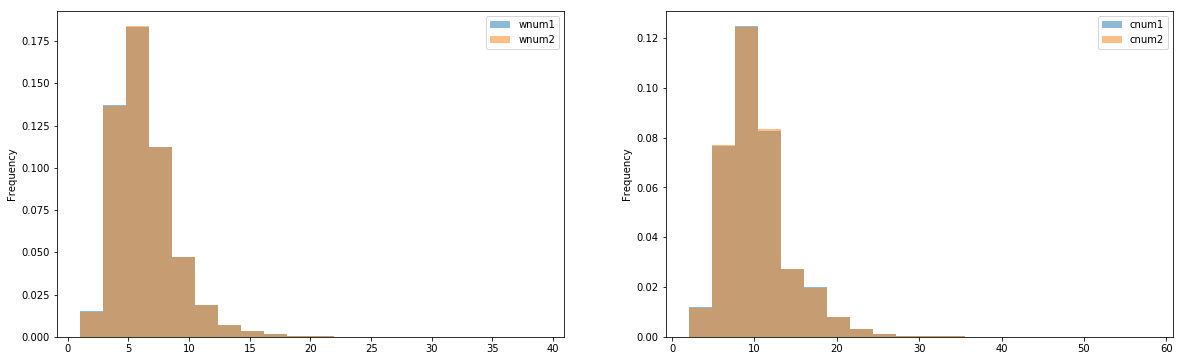

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
train_list.plot(kind="hist", y=["wnum1", "wnum2"], bins=20, alpha=0.5, density=True, ax=ax1)
train_list.plot(kind="hist", y=["cnum1", "cnum2"], bins=20, alpha=0.5, density=True, ax=ax2)

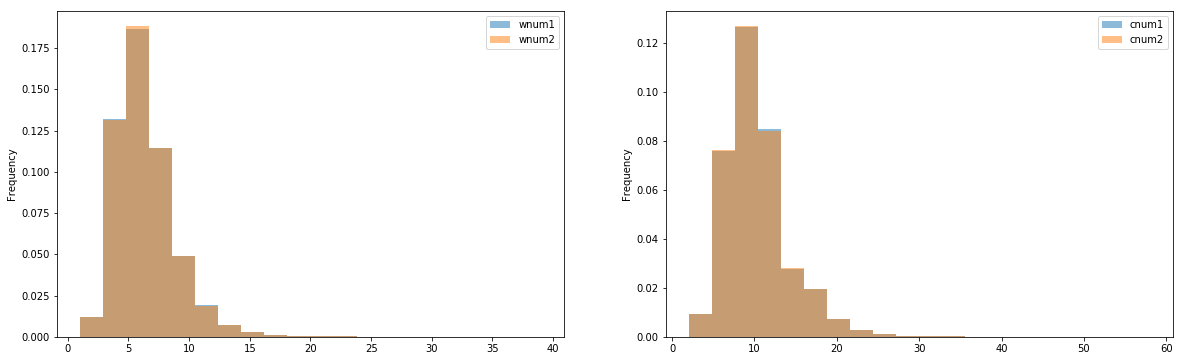

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
test_list.plot(kind="hist", y=["wnum1", "wnum2"], bins=20, alpha=0.5, density=True, ax=ax1)
test_list.plot(kind="hist", y=["cnum1", "cnum2"], bins=20, alpha=0.5, density=True, ax=ax2)

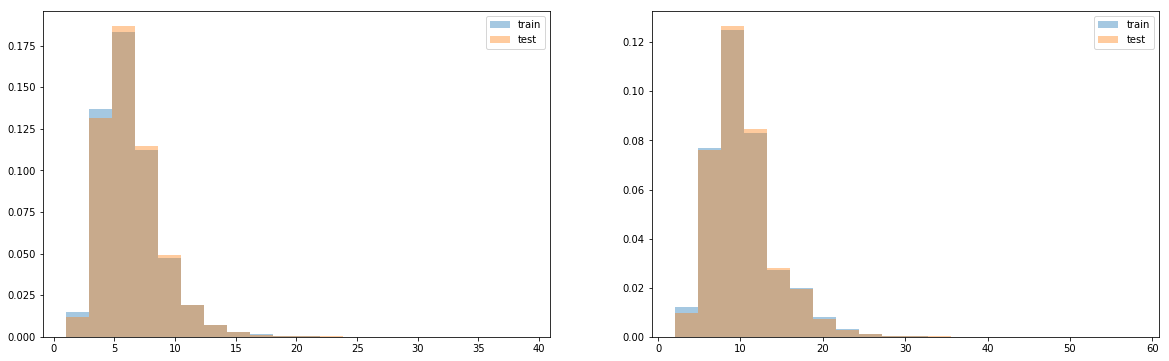

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.hist(train_list["wnum1"], bins=20, label="train", alpha=0.4, density=True)
ax1.hist(test_list["wnum1"], bins=20, label="test", alpha=0.4, density=True)
ax1.legend()
ax2.hist(train_list["cnum1"], bins=20, label="train", alpha=0.4, density=True)
ax2.hist(test_list["cnum1"], bins=20, label="test", alpha=0.4, density=True)
ax2.legend()

**We can see** that the distributions of train and test are highly in accordance.